# Special Works Project
### Creating a watershed delineation workflow
```
This notebook was developed by Tyler W. Davis for the Fall 2021--2022 Advanced GIS course through the Center for Geospatial Analysis at William & Mary (https://www.wm.edu/as/cga/) and is available for use through the MIT Licence (https://mit-license.org/).

Copyright(c) 2021 Tyler W. Davis
```

**Scenario:**  

It is grape vine sowing season in Napa Valley California for the coming year's vineyards and one of the deciding factors in a successful harvest is the availability of water. 
Irrigation plays an important role for this crop and an agricultural firm has asked you to calculate the watershed area (i.e., the area of land that collects rainwater) that feeds their irrigation pump located on Salvador Creek not far from Vintage High School (lat/lon: +38.3326,-122.3107). 

Hear Professor Davis explain more about this project [here (.mp3)](https://drive.google.com/file/d/1VooohsXYCGsWZLOavzFfbGd9HA06H3hF/view).

**Basic Level** 

Follow the outline of watershed delineation process to determine the area of land that drains through the Salvador Creek at (or near) the location of the client's irrigation pump.

1.  Find elevation data for the Napa, CA region
2.  Follow the summarized steps below to define the watershed that has an outlet located at (or near) their irrigation station
3.  Calculate the area of that watershed
4.  Keep track of all the steps that you take, all the geoprocessing tools you use, all the research/reference articles you utilize, and all collaborations you are involved in (and the time you spent doing them)

**Intermediate Level**

Watershed delineation is a multi-step process and the client has expressed interest, if this project is successful, for you to delineate several more watersheds throughout the region. 
Knowing that you will have to repeat this process, you decide to create a model of the procedure so you don't forget any steps and simplify the repeatability.

Produce either a graphical model (e.g., ModelBuilder in ArcGIS or Graphical Modeler in QGIS) or programmatic model (e.g., ArcGIS Notebook) that represents the procedure for watershed delineation and calculate the area of the watershed around Salvador Creek for the client.

**Advanced Level** (_GIS 520_)

The client's pump station is nearing its end-of-life and the client has asked for an analysis of alternative pump station locations.

Provide three alternatives within a 10-mile radius of the existing pump house.
The new basin should be within 20% of the original basin size.
Be sure to justify your choices.

---

**Outline of Watershed Delineation Procedure**

1.  Fill your holes.

    Pre-process the digital elevation raster to ensure that there are no "holes" in the landscape caused by satellite sensor error or processing artifacts from the data provider, which would result in an artificial pond or lake forming where there isn't one.
2.  Water always flows downhill. 
    
    In a raster format, rainwater that falls on a pixel will travel to one of its eight neighbors based on which one has the lowest relative elevation (i.e., downhill). 
    Determine the over-land [flow direction](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-flow-direction-works.htm) based on the filled digital elevation model.
3.  The snowball effect.

    In raster format, each pixel drains to its neighbor with the steepest drop in elevation. 
    As water travels downhill, it follows the paths of others and picks up water drops along the way. 
    This represents a cumulating effect as water passes over the pixels of a given surface raster. 
    The larger the accumulated water, the more likely it will develop into a river or stream when it rains.
    Determine the [flow accumulation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-flow-accumulation-works.htm) based on the flow direction dataset.
4.  Every watershed is defined by its outlet. 

    Pick a point (any point) in the flow accumulation raster and each point has the associated pixels scattered over the landscape where the rainwater that landed there ended up flowing over that point.
    This means that every pixel in the flow accumulation layer has an associated drainage area (i.e., watershed) associated with it.
    The larger the flow accumulation value, the larger the associated drainage area.
    Find the pour point (i.e., the pixel in your flow accumulation that has the highest flow accumulation value proximal to your outlet location) that is best for the pump station.
5.  Delineate the watershed based on the pour point and flow direction data.
6.  Calculate the area of the watershed you found.
    
    TMTOWTDI (there's more than one way to do it).

### The ArcGIS Pro Notebook
Below is the ModelBuilder graphical process of delineating our watershed for an area in Napa California.

![Special Works Watershed Tool](https://wm-gis.maps.arcgis.com/sharing/rest/content/items/760c99345a6f48d8a646b63690b6215c/data)

#### Part 1 - Getting Python Ready for our Analysis

1. loading the necessary libraries into Python
1. checking out the spatial analyst tools
1. setting up the workspace environment
1. allow overwriting of spatial layers

In [19]:
# import necessary modules
import os
from zipfile import ZipFile

import arcpy

In [20]:
# Make sure we have access to spatial analyst tools
arcpy.CheckOutExtension("spatial")

'CheckedOut'

Upload a zipped copy of our file geodatabase and then unzip it.

In [4]:
my_dir = "/arcgis/home/special_works"
my_gdb_name = "wshed_1.gdb.zip"
my_gdb_path = os.path.join(my_dir, my_gdb_name)
os.path.isfile(my_gdb_path)

True

In [7]:
# Open my zip file
z = ZipFile(my_gdb_path, 'r')

In [12]:
# Extract everythin to our folder
z.extractall(path=my_dir)

In [13]:
# Always close the handle when you're done
z.close()

Set the folder and file geodbase path for this online environment

In [21]:
# Set our workspace to our file geodatabase
my_gdb = os.path.join(my_dir, "wshed_1.gdb")
print(my_gdb)
print(os.path.isdir(my_gdb))
arcpy.EnvManager(scratchWorkspace=my_gdb, workspace=my_gdb)   # this doesn't work in AGOL

/arcgis/home/special_works/wshed_1.gdb
True


In [25]:
# Manually store our workspace here
arcpy.env.workspace = my_gdb
arcpy.env.workspace

'/arcgis/home/special_works/wshed_1.gdb'

In [23]:
# Let's allow file overwriting
arcpy.env.overwriteOutput = True

#### Part 2 - Define Parameters

In [26]:
input_dem_raster = "napa_dem"
input_outlet_table = "outlet_geo_txt"
output_coords_system = arcpy.Describe(input_dem_raster).spatialReference
snap_dist = 150
output_watershed_raster = "napa_wshed"

In [27]:
output_coords_system

type,Projected
name,NAD_1927_UTM_Zone_10N
factoryCode,26710
linearUnitName,Meter
GCS.name,GCS_North_American_1927


#### Part 3 - Define our Process

In [28]:
# Process: Fill (Fill) (sa)
Fill = "napa_fill"
napa_fill = arcpy.sa.Fill(
    in_surface_raster=input_dem_raster, 
    z_limit=None
)
#napa_fill.save(Fill)

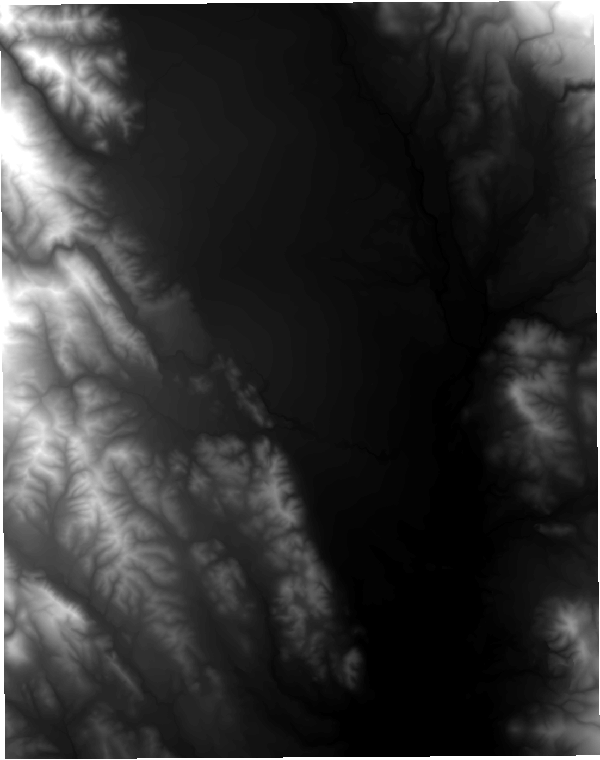

In [29]:
napa_fill

In [30]:
# Process: Flow Direction (Flow Direction) (sa)
Flow_Direction = "napa_fdr"
napa_fdr = arcpy.sa.FlowDirection(
    in_surface_raster=napa_fill, 
    force_flow="NORMAL", 
    out_drop_raster="", 
    flow_direction_type="D8"
)
#napa_fdr.save(Flow_Direction)

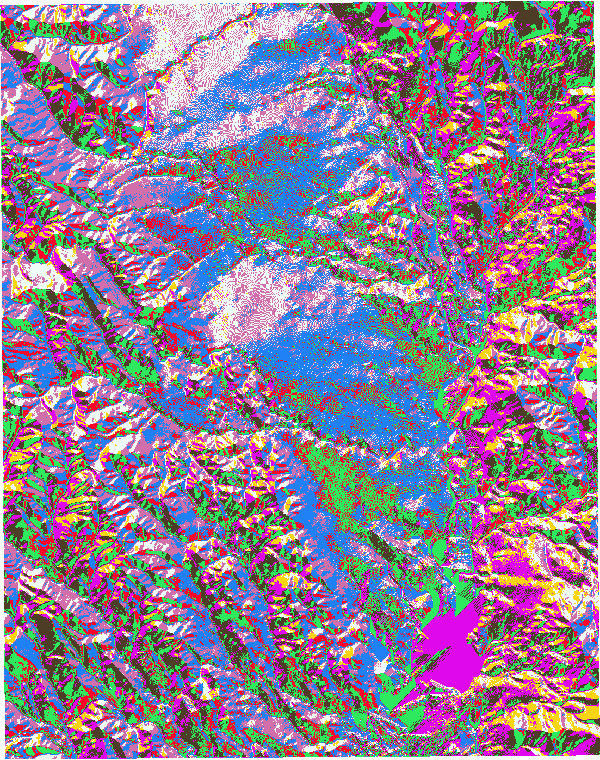

In [31]:
napa_fdr

In [32]:
# Define the GCS 1984 for our point location
in_crs = arcpy.SpatialReference("WGS 1984")

In [33]:
# Process: XY Table To Point (XY Table To Point) (management)
outlet_geo = "outlet_geo"
arcpy.management.XYTableToPoint(
    in_table=input_outlet_table, 
    out_feature_class=outlet_geo, 
    x_field="lon", 
    y_field="lat", 
    z_field="", 
    coordinate_system=in_crs
)

<Result '/arcgis/home/special_works/wshed_1.gdb/outlet_geo'>

In [34]:
# Process: Project (Project) (management)
outlet_nad = "outlet_nad"
arcpy.management.Project(
    in_dataset=outlet_geo, 
    out_dataset=outlet_nad, 
    out_coor_system=output_coords_system, 
    transform_method=["NAD_1927_To_WGS_1984_4"],  # this may need updated depending on inputs
    in_coor_system=in_crs, 
    preserve_shape="NO_PRESERVE_SHAPE", 
    max_deviation="", 
    vertical="NO_VERTICAL"
)

<Result '/arcgis/home/special_works/wshed_1.gdb/outlet_nad'>

In [35]:
# Process: Flow Accumulation (Flow Accumulation) (sa)
Flow_Accumulation = "napa_fac"
napa_fac = arcpy.sa.FlowAccumulation(
    in_flow_direction_raster=napa_fdr, 
    in_weight_raster="", 
    data_type="FLOAT", 
    flow_direction_type="D8"
)
#napa_fac.save(Flow_Accumulation)

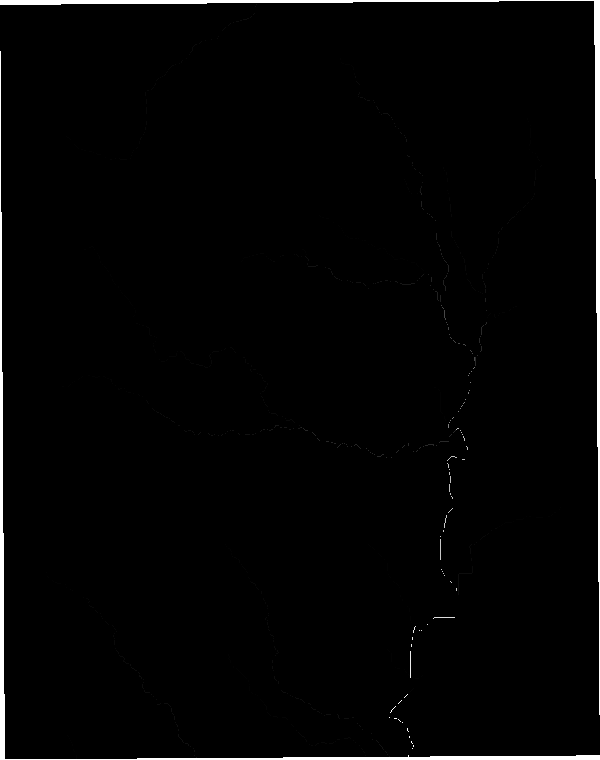

In [36]:
napa_fac

In [37]:
# Process: Snap Pour Point (Snap Pour Point) (sa)
Snap_Pour_Point = "snap_pour"
snap_pour = arcpy.sa.SnapPourPoint(
    in_pour_point_data=outlet_nad, 
    in_accumulation_raster=napa_fac, 
    snap_distance=snap_dist, 
    pour_point_field="id"
)
#snap_pour.save(Snap_Pour_Point)

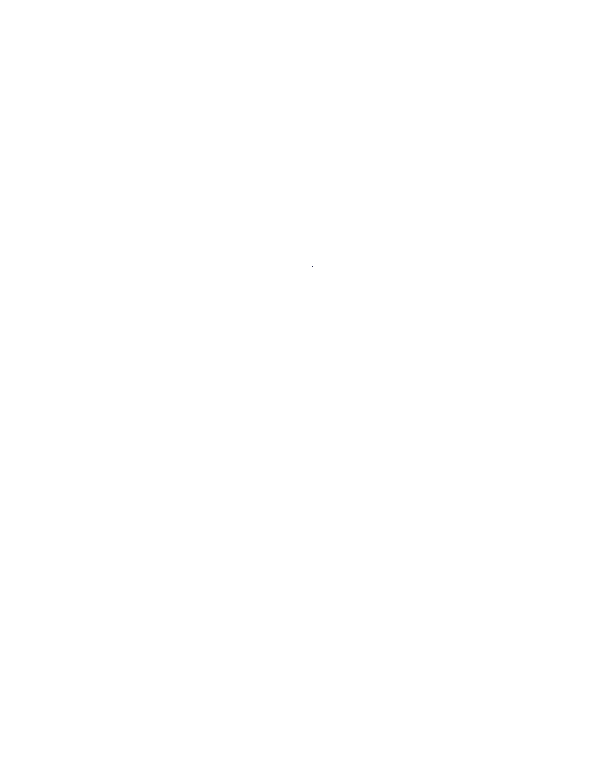

In [38]:
# I can't even see the single pixel (too small?)
snap_pour

In [39]:
# Process: Watershed (Watershed) (sa)
Watershed = output_watershed_raster
Output_Watershed_Raster_Layer = arcpy.sa.Watershed(
    in_flow_direction_raster=napa_fdr, 
    in_pour_point_data=snap_pour, 
    pour_point_field="Value"
)
Output_Watershed_Raster_Layer.save(Watershed)

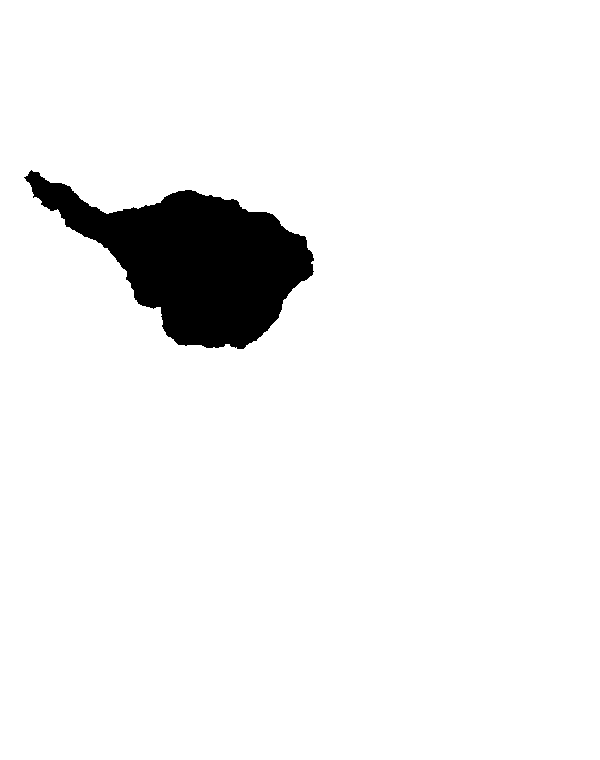

In [40]:
Output_Watershed_Raster_Layer

In [43]:
# List feature classes in our FGDB:
arcpy.ListFeatureClasses()

['outlet_geo', 'outlet_nad']

In [47]:
# List raster datasets in our FGDB
arcpy.ListDatasets("", "Raster")

['napa_dem',
 'Fill_napa_de1',
 'FlowDir_Fill1',
 'FlowAcc_Flow1',
 'SnapPou_outl1',
 'napa_wshed']